<a href="https://colab.research.google.com/github/farenga/meshgnn/blob/main/meshGNN_test_0429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.9 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 4.6 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 4.6 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 4.6 MB/s 
     |████████████████████████████████| 407 kB 5.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=a7764daa17cafa5b59d2b1356eb543b1dc70b7b3ea838e073b8d0aeb604221bb
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [2]:
import numpy as np
import torch_geometric
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import scipy.io
import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/University/Courses/NAPDE-Project/data

Mounted at /gdrive
/gdrive/MyDrive/University/Courses/NAPDE-Project/data


In [118]:
dataset_type = 'voro50'

if dataset_type=='square':
  areas = torch.tensor(scipy.io.loadmat('AreaVectors_square.mat')['AreaVectors'],dtype=torch.float)
  coords = torch.tensor(scipy.io.loadmat('CoordMatrices_square.mat')['CoordMatrices'],dtype=torch.float)
  adjacencies = torch.tensor(scipy.io.loadmat('AdjacencyMatrices_square.mat')['AdjacencyMatrices'])
  areas = areas.unsqueeze(-1)
  coords = coords.unsqueeze(-1)
  adjacencies = adjacencies.unsqueeze(-1)

if dataset_type=='voronoi':
  areas = torch.tensor(scipy.io.loadmat('AreaVectors_voronoi.mat')['AreaVectors'],dtype=torch.float)
  coords = torch.tensor(scipy.io.loadmat('CoordMatrices_voronoi.mat')['CoordMatrices'],dtype=torch.float)
  adjacencies = torch.tensor(scipy.io.loadmat('AdjacencyMatrices_voronoi.mat')['AdjacencyMatrices'])
  

if dataset_type=='Complete':
  areas = torch.tensor(scipy.io.loadmat('AreaVectors.mat')['AreaVectors'],dtype=torch.float)
  coords = torch.tensor(scipy.io.loadmat('CoordMatrices.mat')['CoordMatrices'],dtype=torch.float)
  adjacencies = torch.tensor(scipy.io.loadmat('AdjacencyMatrices.mat')['AdjacencyMatrices'])
  meshsizes = torch.tensor(scipy.io.loadmat('Meshsizes.mat')['Meshsizes'])
  dataset_size = areas.shape[-1]

if dataset_type=='voro100':
  areas = torch.tensor(scipy.io.loadmat('AreaVectors_voro100.mat')['AreaVectors'],dtype=torch.float)
  coords = torch.tensor(scipy.io.loadmat('CoordMatrices_voro100.mat')['CoordMatrices'],dtype=torch.float)
  adjacencies = torch.tensor(scipy.io.loadmat('AdjacencyMatrices_voro100.mat')['AdjacencyMatrices'])
  meshsizes = torch.tensor(scipy.io.loadmat('Meshsizes_voro100.mat')['Meshsizes']).t()
  dataset_size = areas.shape[-1]

if dataset_type=='voro50':
  areas = scipy.io.loadmat('AreaVectors_voro50.mat')['AreaVectors']
  coords = scipy.io.loadmat('CoordMatrices_voro50.mat')['CoordMatrices']
  adjacencies = scipy.io.loadmat('AdjacencyMatrices_voro50.mat')['AdjacencyMatrices']
  #meshsizes = torch.tensor(scipy.io.loadmat('Meshsizes_voro50.mat')['Meshsizes']).t()
  dataset_size = areas.shape[-1]

In [119]:
areas.shape, coords.shape, adjacencies.shape

((1, 50), (1, 50), (1, 50))

In [120]:
adjacencies[0,0].shape

(22, 22)

In [167]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import softmax


class GCN(torch.nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.convIn = torch_geometric.nn.SAGEConv(3, hidden_units)
        self.conv2 = torch_geometric.nn.SAGEConv(hidden_units, hidden_units)
        self.conv3 = torch_geometric.nn.SAGEConv(hidden_units, hidden_units)
        self.convOut = torch_geometric.nn.SAGEConv(hidden_units, 2)

    def forward(self, x, edge_index):
        x = self.convIn(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)
        x = x.tanh()
        x = self.convOut(x, edge_index)
        x = nn.Softmax(dim=1)(x)
        return x

model = GCN(hidden_units=32)
print(model)

GCN(
  (convIn): SAGEConv(3, 32)
  (conv2): SAGEConv(32, 32)
  (conv3): SAGEConv(32, 32)
  (convOut): SAGEConv(32, 2)
)


In [165]:
from torch_geometric.utils import degree
def loss_normalized_cut(y,graph):
  d=degree(graph.edge_index[0],num_nodes = y.size(0))
  gamma = torch.t( y) @ d
  c = torch.sum(y[ graph.edge_index[0],0]*y[graph.edge_index[1],1])
  
  outclass = torch.tensor(y>=.5,dtype=torch.float)
  areas = torch.matmul(graph.x[:,-1].t(),outclass)

  return torch.sum(torch.div(c,gamma)) + torch.pow(areas[0]-areas[1],2)

In [174]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#criterion = torch.nn.CrossEntropyLoss()
batch_size = 32
def train(loss_array):
      model.train()
      optimizer.zero_grad()
      for i in np.arange(0,dataset_size-batch_size,batch_size):
        loss = 0
        for j in range(0,batch_size):
          #sample_idx_rnd = np.random.randint(0,adjacencies.shape[-1])
          coords_tensor_sample = torch.tensor(coords[0,i+j],dtype=torch.float)
          #coords_tensor_sample = coords_tensor_sample + np.random.normal()*torch.ones_like(coords_tensor_sample)
          areas_tensor_sample = torch.tensor(areas[0,i+j],dtype=torch.float)
          x = torch.cat([coords_tensor_sample,areas_tensor_sample],-1)
          A = torch.tensor(adjacencies[0,i+j])
          edge_index = (A > 0).nonzero().t()
          data = Data(x=x, edge_index=edge_index)
          out = model(data.x, data.edge_index)  
          loss = loss + loss_normalized_cut(out, data )  
        loss.backward()  
        optimizer.step()  
        loss_array.append(loss.item())

loss_array = []
for epoch in range(1, 1000+1):
    train(loss_array)
    if epoch==1 or epoch%50==0:
      print(f'epoch: {epoch:03d}, loss: {loss_array[-1]:.4f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


epoch: 001, loss: 12.1770
epoch: 050, loss: 11.8986
epoch: 100, loss: 12.1762
epoch: 150, loss: 12.1758
epoch: 200, loss: 12.1753
epoch: 250, loss: 12.1749
epoch: 300, loss: 12.1745
epoch: 350, loss: 12.1741
epoch: 400, loss: 12.1737
epoch: 450, loss: 12.1733
epoch: 500, loss: 12.1729
epoch: 550, loss: 12.1725
epoch: 600, loss: 12.1722
epoch: 650, loss: 12.1718
epoch: 700, loss: 12.1714
epoch: 750, loss: 12.1710
epoch: 800, loss: 12.1706
epoch: 850, loss: 12.1703
epoch: 900, loss: 12.1699
epoch: 950, loss: 12.1695
epoch: 1000, loss: 12.1691


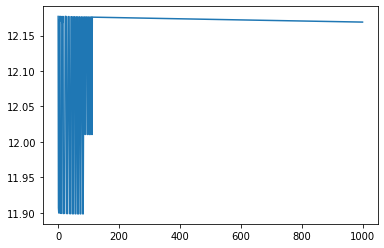

In [175]:
plt.plot(loss_array[:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Sample Index:  0
Area1:  tensor(0.0069)   |  Area2:  tensor(0.1772) 


Sample Index:  1
Area1:  tensor(0.3824)   |  Area2:  tensor(0.4285) 


Sample Index:  2
Area1:  tensor(0.4168)   |  Area2:  tensor(0.3628) 


Sample Index:  3
Area1:  tensor(0.1423)   |  Area2:  tensor(0.4967) 


Sample Index:  4
Area1:  tensor(0.5633)   |  Area2:  tensor(0.4405) 


Sample Index:  5
Area1:  tensor(0.2652)   |  Area2:  tensor(0.2625) 


Sample Index:  6
Area1:  tensor(0.6931)   |  Area2:  tensor(0.2469) 


Sample Index:  7
Area1:  tensor(0.3170)   |  Area2:  tensor(0.3178) 


Sample Index:  8
Area1:  tensor(0.7203)   |  Area2:  tensor(0.5480) 


Sample Index:  9
Area1:  tensor(0.5225)   |  Area2:  tensor(0.3037) 


Sample Index:  10
Area1:  tensor(0.6047)   |  Area2:  tensor(0.2269) 


Sample Index:  11
Area1:  tensor(0.4511)   |  Area2:  tensor(0.3598) 


Sample Index:  12
Area1:  tensor(0.)   |  Area2:  tensor(0.2043) 


Sample Index:  13
Area1:  tensor(0.4756)   |  Area2:  tensor(0.4375) 


Sampl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Sample Index:  21
Area1:  tensor(0.4838)   |  Area2:  tensor(0.3273) 


Sample Index:  22
Area1:  tensor(0.2774)   |  Area2:  tensor(0.3705) 


Sample Index:  23
Area1:  tensor(0.2651)   |  Area2:  tensor(0.2878) 


Sample Index:  24
Area1:  tensor(0.0901)   |  Area2:  tensor(0.3880) 


Sample Index:  25
Area1:  tensor(0.4204)   |  Area2:  tensor(0.1206) 


Sample Index:  26
Area1:  tensor(0.2240)   |  Area2:  tensor(0.5116) 


Sample Index:  27
Area1:  tensor(0.5987)   |  Area2:  tensor(0.4000) 


Sample Index:  28
Area1:  tensor(0.4985)   |  Area2:  tensor(0.4033) 


Sample Index:  29
Area1:  tensor(0.0922)   |  Area2:  tensor(0.3944) 


Sample Index:  30
Area1:  tensor(0.5609)   |  Area2:  tensor(0.2283) 


Sample Index:  31
Area1:  tensor(0.2713)   |  Area2:  tensor(0.3132) 


Sample Index:  32
Area1:  tensor(0.)   |  Area2:  tensor(0.1745) 


Sample Index:  33
Area1:  tensor(0.6518)   |  Area2:  tensor(0.2463) 


Sample Index:  34
Area1:  tensor(0.5614)   |  Area2:  tensor(0.2959

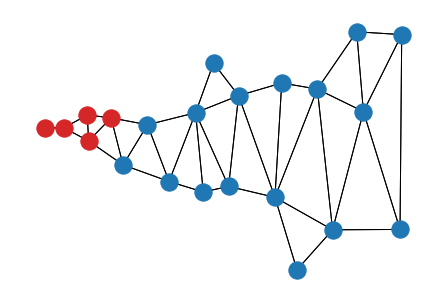

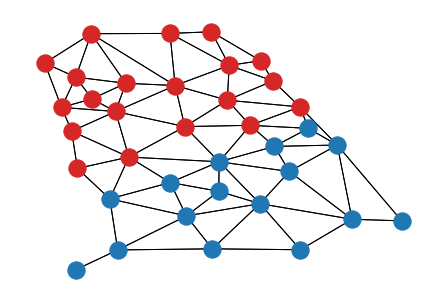

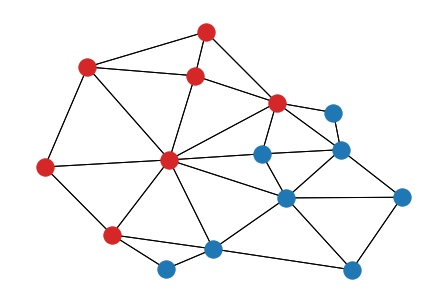

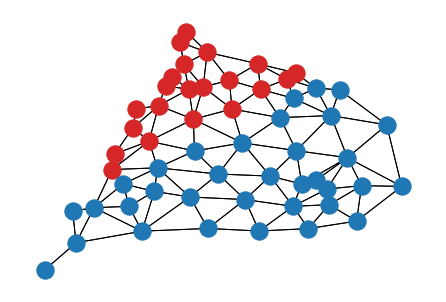

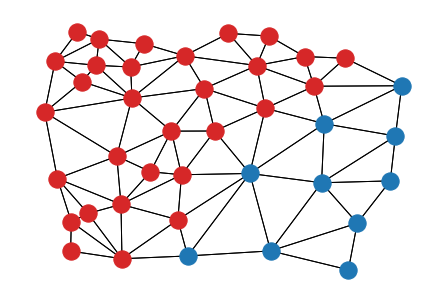

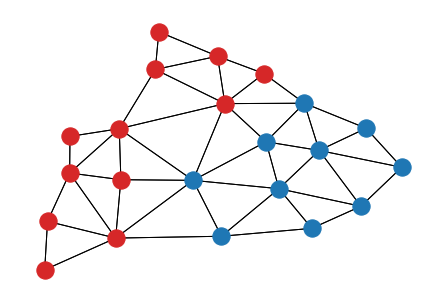

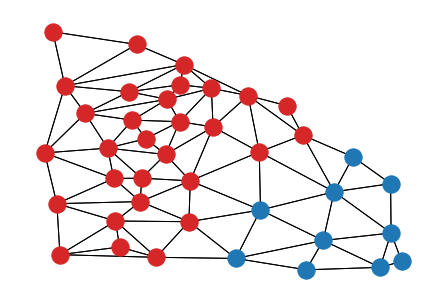

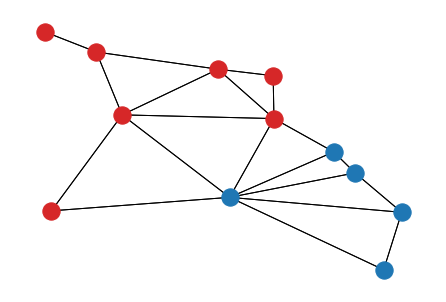

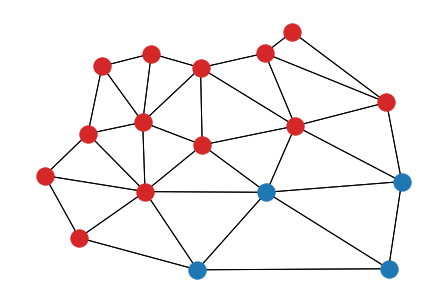

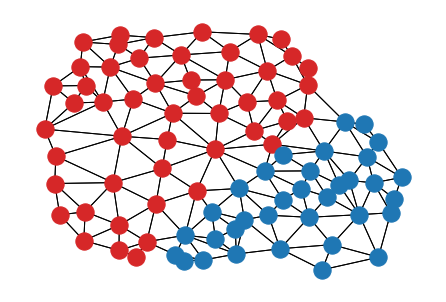

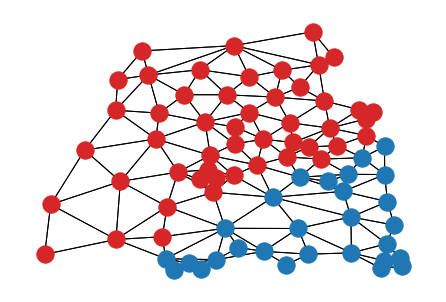

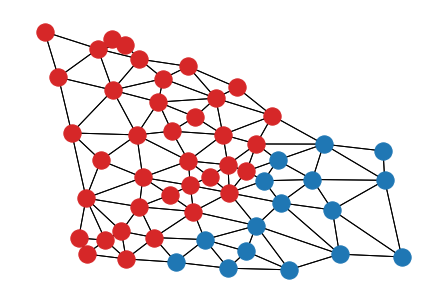

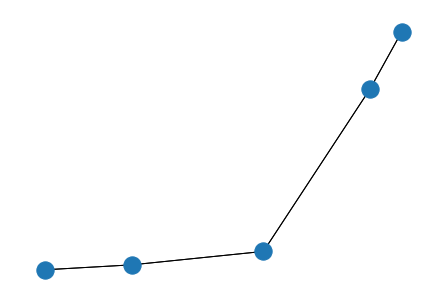

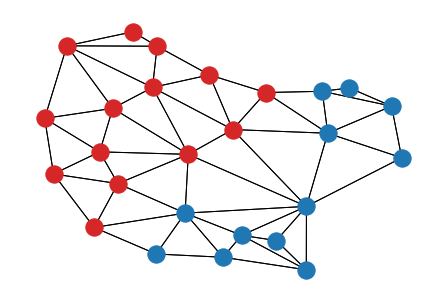

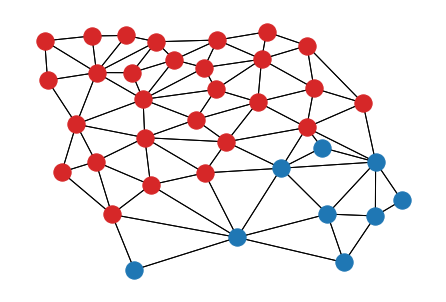

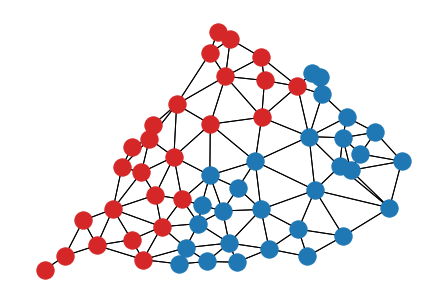

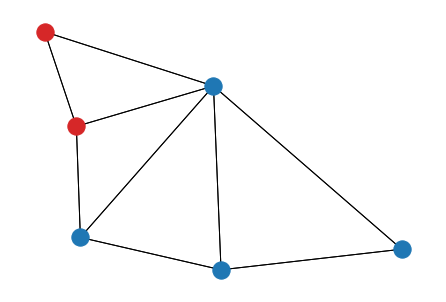

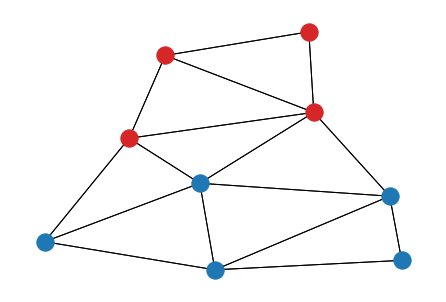

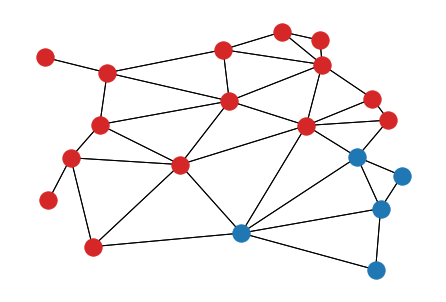

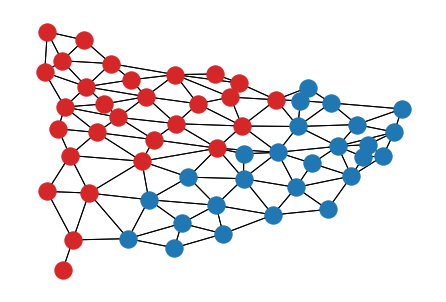

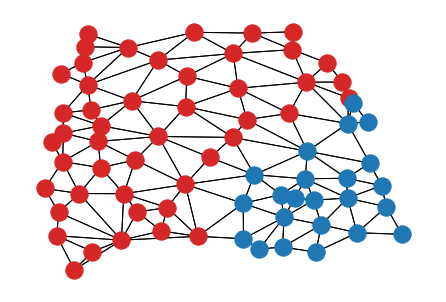

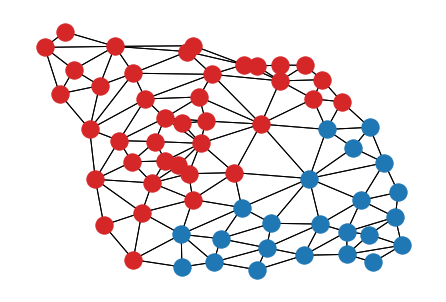

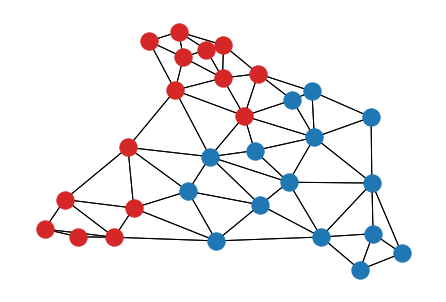

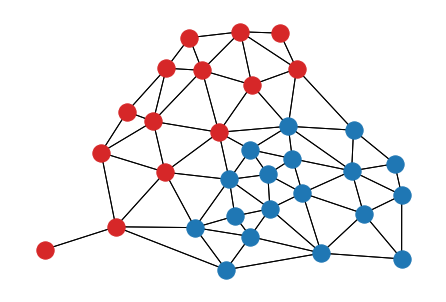

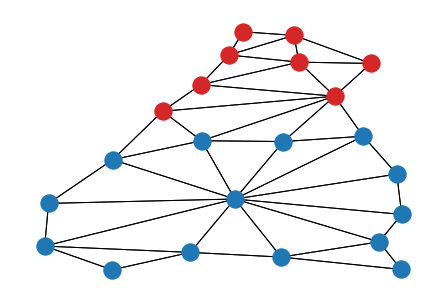

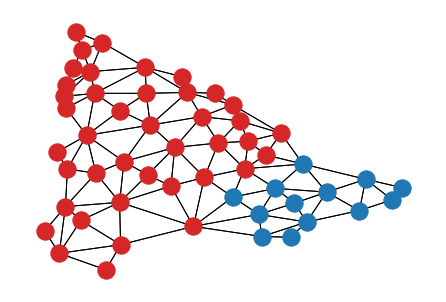

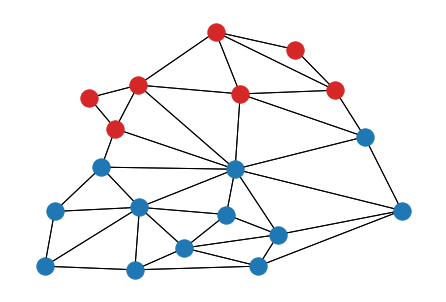

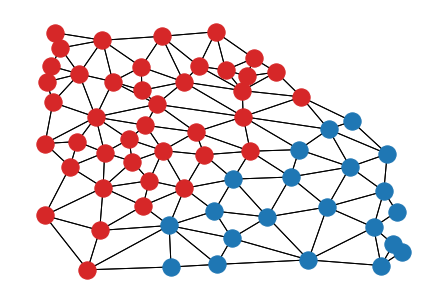

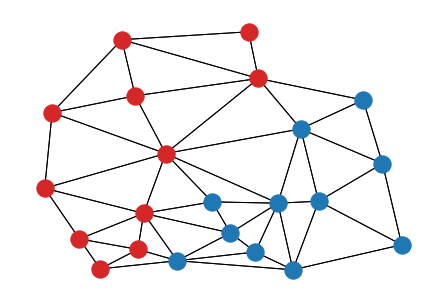

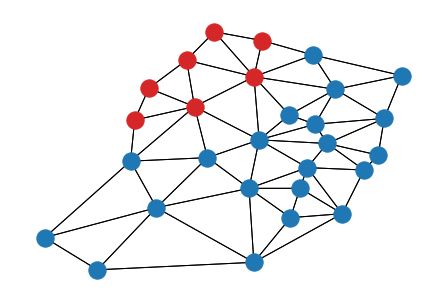

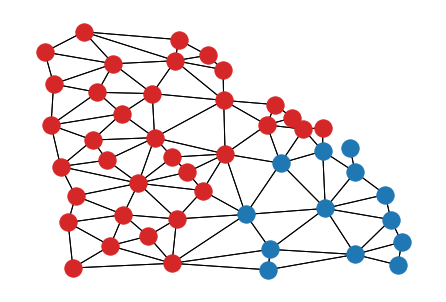

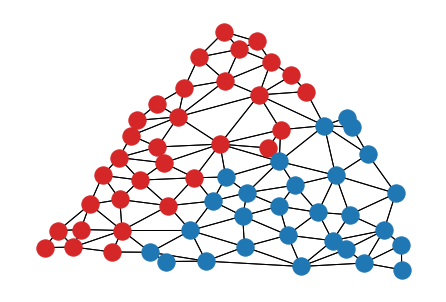

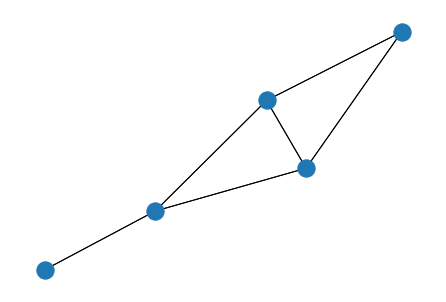

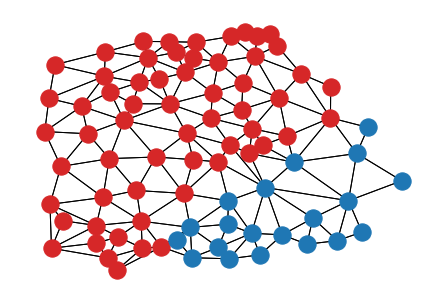

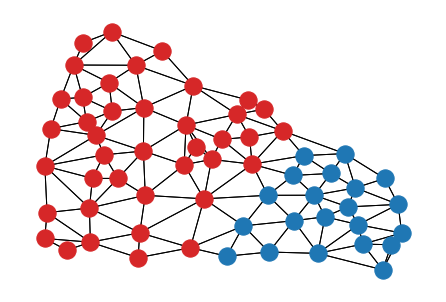

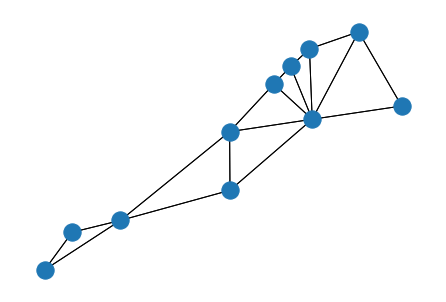

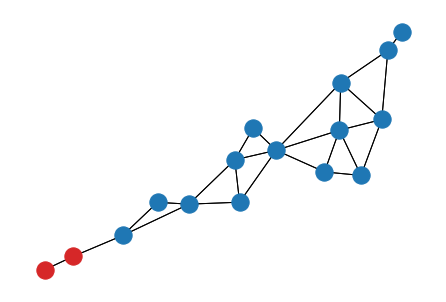

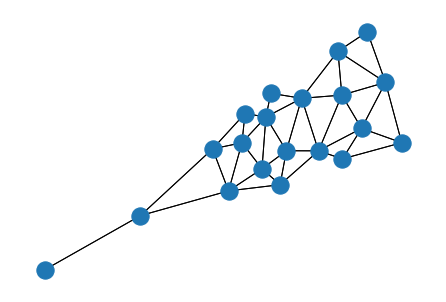

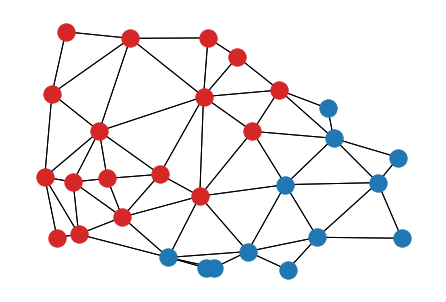

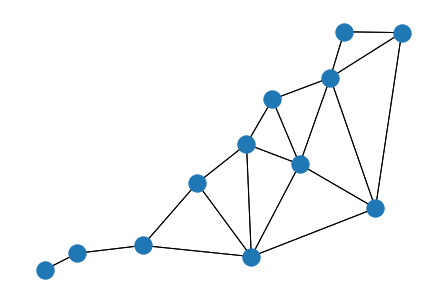

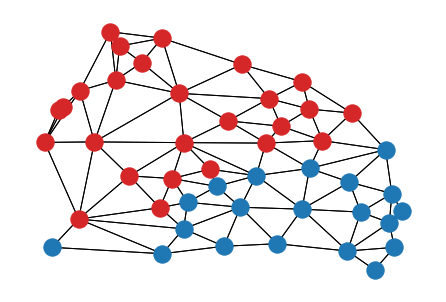

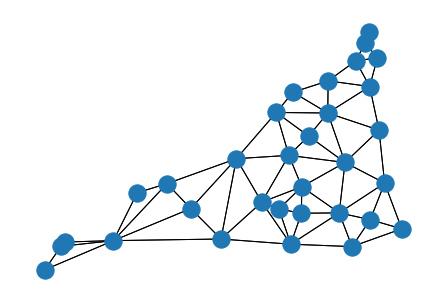

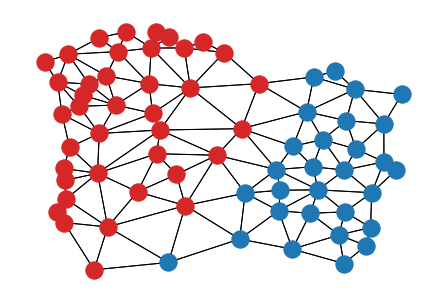

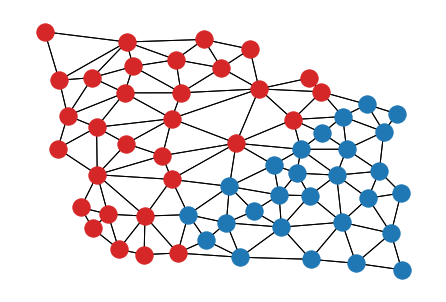

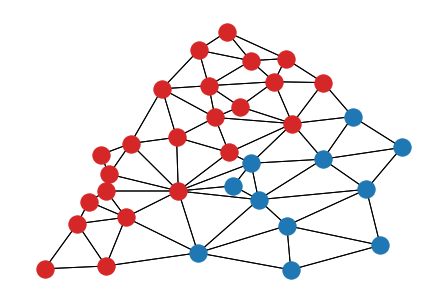

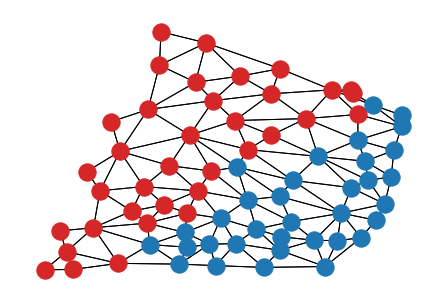

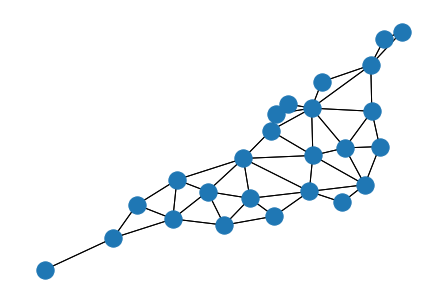

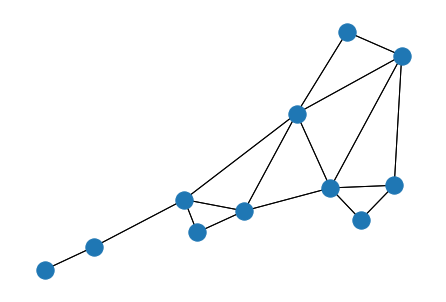

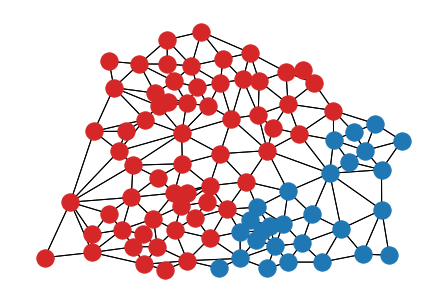

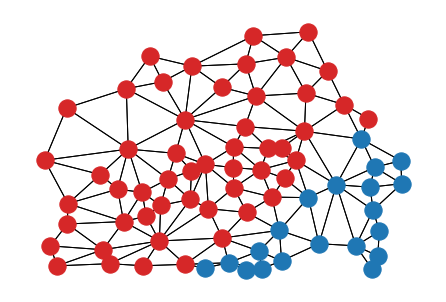

In [176]:
model.eval()
for sample_idx in range(dataset_size):
  x_test = torch.cat([torch.tensor(coords[0,sample_idx],dtype=torch.float),torch.tensor(areas[0,sample_idx],dtype=torch.float)],-1)
  A_test = torch.tensor(adjacencies[0,sample_idx])
  edge_index_test = (A_test > 0).nonzero().t()
  data_test = Data(x=x_test, edge_index=edge_index_test)

  out = model(data_test.x, data_test.edge_index)

  outclass = torch.tensor(out>.5,dtype=torch.bool)
  class1 = outclass[:,0]
  class2 = outclass[:,1]  
  class1_idx = np.transpose(np.nonzero(class1))[0]
  class2_idx = np.transpose(np.nonzero(class2))[0]
  plt.figure()
  g = torch_geometric.utils.to_networkx(data_test, to_undirected=True)
  nx.draw(g,coords[0,sample_idx].tolist(),nodelist=class1_idx.tolist(), node_color="tab:red")
  nx.draw(g,coords[0,sample_idx].tolist(),nodelist=class2_idx.tolist(), node_color="tab:blue")

  # Areas
  areas_class1 = areas[0,sample_idx][class1]
  areas_class2 = areas[0,sample_idx][class2]
  area1 = sum(areas_class1)
  area2 = sum(areas_class2)
  print('\nSample Index: ', sample_idx)
  #print('Area1: ', area1.item(),'  |  Area2: ', area2.item(),'\n')
  outclass = torch.tensor(out>.5,dtype=torch.float)
  areasums = torch.matmul(data_test.x[:,-1].t(),outclass)
  print('Area1: ', areasums[0],'  |  Area2: ', areasums[1],'\n')
  


In [75]:
area1

array([0.52505548])

In [101]:
#!mkdir saved_models
torch.save(model.state_dict(),'saved_models/model_2.pt')